# Customer Churn Prediction Lab: Decision Tree Tuning

## Business Scenario

You work as a data scientist for a telecommunications company that is concerned about customer churn. The company has collected data on various customer attributes and behaviors, including demographics, account information, and service usage patterns.

Your task is to build a decision tree model that can predict whether a customer is likely to churn (cancel their service) in the near future. This will allow the company to proactively reach out to at-risk customers with retention offers.

### Recall as a Critical Metric for Churn Prediction
In the context of customer churn prediction, recall is particularly important for business reasons that directly affect the bottom line. Recall measures the proportion of actual churners that your model correctly identifies.

Why Recall Matters More Than Precision for Churn:

When predicting customer churn, the cost of a false negative (missing a churning customer) is typically much higher than the cost of a false positive (incorrectly flagging a loyal customer as at-risk).

The business cost of missing a churner (false negative):
- Complete loss of future revenue from that customer
- Increased customer acquisition costs to replace them
- Potential negative word-of-mouth effects
- Lost opportunity to address their concerns and retain them

The business cost of incorrectly flagging a non-churner (false positive):
- Resources spent on unnecessary retention efforts (discounts, outreach)
- Minor potential annoyance to the satisfied customer

In most subscription businesses, acquiring a new customer costs 5-25 times more than retaining an existing one. This asymmetric cost structure makes missing a churning customer (low recall) much more expensive than incorrectly identifying a loyal customer as at-risk.

**You are expected to use recall to score and evaluate your models.**

## The Process

By the end of this lab, you will have:
1. Established a baseline decision tree model and evaluated its performance
2. Performed hyperparameter tuning using randomized search
3. Refined the model using grid search
4. Evaluated final model performance



## Part 0: Setup - Import Libraries and Load Data

First, let's import all the necessary libraries and load our dataset.

In [1]:
# CodeGrade step0
# Import required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay

# Set random seed for reproducibility
np.random.seed(42)

### Loading and exploring the dataset

The dataset contains customer information and a target variable 'churn' indicating whether they cancelled their service (1) or not (0).

In [2]:
# CodeGrade step0
# Run this cell without changes
# Load the dataset
df_telco = pd.read_csv('telecom_churn_processed.csv')

In [3]:
# Run this cell without changes
# Display basic information about the dataset
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   account_age_months  20000 non-null  int64  
 1   monthly_charges     20000 non-null  float64
 2   subscription_tier   20000 non-null  int64  
 3   support_calls       20000 non-null  int64  
 4   reported_issues     20000 non-null  int64  
 5   inactive_days       20000 non-null  int64  
 6   usage_decline       20000 non-null  float64
 7   competitor_offer    20000 non-null  int64  
 8   promotion_response  20000 non-null  int64  
 9   contract_type       20000 non-null  int64  
 10  payment_method      20000 non-null  int64  
 11  online_security     20000 non-null  int64  
 12  tech_support        20000 non-null  int64  
 13  churn               20000 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 2.1 MB


In [4]:
# Run this cell without changes
# Check the first few rows of the dataset
df_telco.head()

,account_age_months,monthly_charges,subscription_tier,support_calls,reported_issues,inactive_days,usage_decline,competitor_offer,promotion_response,contract_type,payment_method,online_security,tech_support,churn
0,12,73.73,3,3,2,7,8.9,0,0,2,0,0,0,0
1,35,58.23,1,5,3,18,18.6,0,1,0,3,1,0,0
2,32,57.90,2,5,2,16,22.5,1,0,2,0,1,1,0
3,17,85.43,2,5,2,12,10.0,0,0,1,0,1,0,0
4,41,87.41,1,3,3,22,20.3,1,1,1,1,0,0,1


In [5]:
# Run this cell without changes
# Check the distribution of the target variable
df_telco['churn'].value_counts(normalize=True)

churn
0    0.6573
1    0.3427
Name: proportion, dtype: float64

## Part 1: Initial Assessment

Establish a baseline DecisionTree model using default parameters to understand how well a basic decision tree performs on our data.

### Data Preparation

Prepare your data for modeling. For simplicity, we'll assume the data is already preprocessed, but in a real scenario, you would need to handle missing values, encode categorical variables, etc.
- Use a 75-25 split
- And set `random_state` = 42 for both the split and the Decision Tree Model

In [6]:
# CodeGrade step1
# Replace None with your code
# Prepare features (X) and target (y)
# Select all columns except 'churn' as features
# Use 'churn' as the target variable

X = df_telco.drop('churn', axis=1)
y = df_telco['churn']

# Splitting the data into training and testing sets (use a 75-25 split, and random_state of 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
# CodeGrade step2
# Replace None with your code
# Create a baseline decision tree classifier with default parameters (set random_state = 42)
baseline_model = DecisionTreeClassifier(random_state=42)

# Perform cross-validation to get a robust estimate of model performance
# Set scoring = 'recall'
# Should be a list of scores
baseline_scores = cross_val_score(baseline_model, X_train, y_train, scoring='recall')

In [8]:
# CodeGrade step3
# Fit the baseline model to the training data to examine feature importance
baseline_fit = baseline_model.fit(X_train, y_train)

# Get training predictions
baseline_train_preds = baseline_model.predict(X_train)

# Get the training recall score
baseline_train_score = recall_score(y_train, baseline_train_preds)

# Create a dictionary of feature importances (feature_name : importance_value)
initial_importance_df = pd.DataFrame({'feature_name': X.columns, 'importance_value': baseline_fit.feature_importances_}).sort_values('importance_value', ascending=False)
initial_importance = initial_importance_df.to_dict()

In [9]:
# Run this cell without changes
# Display CV and training scores
print(f"Baseline model training recall: {baseline_train_score:.3f}")
print(f"Baseline model Cross-Val recall: {baseline_scores.mean():.3f}")
# Display feature importances
print("\nInitial Feature Importance:")
initial_importance

Baseline model training recall: 1.000
Baseline model Cross-Val recall: 0.879

Initial Feature Importance:


{'feature_name': {1: 'monthly_charges',
  2: 'subscription_tier',
  6: 'usage_decline',
  3: 'support_calls',
  0: 'account_age_months',
  7: 'competitor_offer',
  4: 'reported_issues',
  5: 'inactive_days',
  10: 'payment_method',
  9: 'contract_type',
  11: 'online_security',
  8: 'promotion_response',
  12: 'tech_support'},
 'importance_value': {1: 0.22060853927155513,
  2: 0.21704594611507125,
  6: 0.16356821377046804,
  3: 0.15479648491392706,
  0: 0.08808555055816054,
  7: 0.07245078521739083,
  4: 0.03500005051672818,
  5: 0.022428668257850226,
  10: 0.007437033337929767,
  9: 0.007049342315745822,
  11: 0.005395264974164206,
  8: 0.003693311069402509,
  12: 0.002440809681606458}}

In [10]:
baseline_model.get_depth()

28

### Analyzing the baseline model

Now, let's reflect on what we've learned from the baseline model.

1. Is our model overfitting, underfitting, or balanced? How can you tell?
2. Which features appear to be most important for predicting churn?
3. Based on your findings, what should be your focus in hyperparameter tuning?

This model is overfitting-it perfectly fits the training data, but has a lower recall on the cross-validation.

The three features that had the highest feature importance scores (and therefore appear to be the strongest predictors of churn) are *subscription_tier*, *usage_decline*, and *support_calls*.

My focus in hyperparameter tuning will be to reduce the overfitting of model by increasing the cv recall score and bringing it closer to the training recall score.

## Part 2: Broad Exploration with Randomized Search

Now, use randomized search to efficiently explore a broad parameter space. This will help us identify promising regions without evaluating every possible parameter combination. Include the following hyperparameters and distributions in your RandomizedSearch.
- 'criterion': ['gini', 'entropy', 'log_loss']
- 'max_depth': np.arange(3, 100, 2)
- 'min_samples_split': np.arange(2, 21)
- 'min_samples_leaf': np.arange(1, 21)

In [11]:
# CodeGrade step4
# Replace None with your code
# Define parameter distributions for random search
param_dist = {
   'criterion':['gini', 'entropy', 'log_loss'],
   'max_depth': np.arange(3, 100, 2),
   'min_samples_split': np.arange(2, 21),
   'min_samples_leaf': np.arange(1, 21),
}


In [12]:
# CodeGrade step5
# Replace None with your code
# Create base model object (use random_state=42)
model_search = DecisionTreeClassifier(random_state=42)

# Initialize randomized search (ensure you are scoring based on recall)
random_search = RandomizedSearchCV(
   DecisionTreeClassifier(random_state=42),
   param_distributions=param_dist,
   n_iter=100,  # Number of parameter settings sampled
   cv=5,
   scoring='recall',
   n_jobs=-1,
   random_state=42
)

# Perform search (fit to data)
random_search.fit(X_train, y_train)

# Extract results from search
best_parameters_rand = random_search.best_params_
bestcv_score_rand = random_search.best_score_
best_training_score_rand = random_search.best_estimator_.score(X_train, y_train)

In [13]:
# Run this cell without changes
# Print results
print("Best parameters from random search:")
print(best_parameters_rand)
print(f"Best cross-validation score: {bestcv_score_rand:.3f}")
print(f"Best training score: {best_training_score_rand:.3f}")

Best parameters from random search:
{'min_samples_split': 16, 'min_samples_leaf': 9, 'max_depth': 95, 'criterion': 'log_loss'}
Best cross-validation score: 0.899
Best training score: 0.959


### Analyzing the randomized search results

1. How do the best parameters from randomized search compare to the default parameters?
2. Has the model performance improved? By how much?
3. Is there still evidence of overfitting, and if so, has it been reduced?

Here is how the best parameters compare to the defaults:

min_samples_split

- optimized: 16
- default: 2

min_samples_leaf

- optimized: 9
- default: 1

max_depth

- optimized: 95
- default: none
- actual in baseline_model: 28

criterion

- optimized: log_loss
- default: gini

The model performance has indeed improved-the cv score went from 0.879 to 0.899, an increase of 0.02.

There is still evidence of overfitting. The best training score (0.959) is still meaningfully above the best cv score (0.899) but the random search optimization has narrowed this gap and improved the overfitting.

## Part 3: Focused Optimization with Grid Search

Based on the results from randomized search, let's now perform a more focused grid search around the promising parameter regions we've identified.

NOTE: It is okay if your model does not improve or has similar performance as this is often an iterative process while you are only doing one GridSearch here.

In [31]:
# CodeGrade step6
# Define a focused parameter grid based on the best parameters from random search
focused_param_grid = {
    'criterion': ['log_loss'],
    'max_depth': [93, 94, 95, 96, 97],
    'min_samples_leaf': [7, 8, 9, 10, 11],
    'min_samples_split': [14, 15, 16, 17, 18]
}

In [32]:
# CodeGrade step7
# Replace None with your code
# Initialize grid search (make sure to use recall score)
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    focused_param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# Perform GridSearch (fit to data)
grid_search.fit(X_train, y_train)

# Extract results from search
best_parameters_grid = grid_search.best_params_
bestcv_score_grid = grid_search.best_score_
best_training_score_grid = grid_search.best_estimator_.score(X_train, y_train)

In [33]:
# Run this cell without changes
# Print results
print("Best parameters from grid search:")
print(best_parameters_grid)
print(f"Best cross-validation score: {bestcv_score_grid:.3f}")
print(f"Best training score: {best_training_score_grid:.3f}")

Best parameters from grid search:
{'criterion': 'log_loss', 'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 14}
Best cross-validation score: 0.899
Best training score: 0.959


## Part 4: Final Validation

Now, evaluate your final tuned model on the held-out test set to get an unbiased estimate of its performance.

In [34]:
# CodeGrade step8
# Replace None with your code
# Get the best model from your grid search
final_model = DecisionTreeClassifier(
    criterion='log_loss',
    max_depth=93,
    min_samples_leaf=9,
    min_samples_split=14,
    random_state=42)

final_fit = final_model.fit(X_test, y_test)

# Get predictions on test set
y_pred = final_model.predict(X_test)

# Evaluate recall score on the test set
final_test_score = final_model.score(X_test, y_test)

In [35]:
# Run this cell to display results
print("\nFinal Model Evaluation:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Cross-validation recall: {bestcv_score_grid:.3f}")
print(f"Test set recall: {final_test_score:.3f}")


Final Model Evaluation:
Best parameters: {'criterion': 'log_loss', 'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 14}
Cross-validation recall: 0.899
Test set recall: 0.954


In [36]:
# CodeGrade step9
# Replace None with your code
# Calculate confusion matrix on testing data
cm = confusion_matrix(y_test, y_pred)

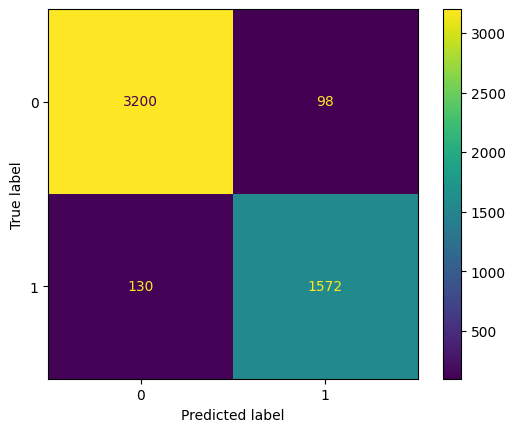

In [37]:
# Run this cell without changes
# Code for plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=final_model.classes_)
disp.plot();

In [38]:
# CodeGrade step10
# Replace None with your code
# Extract feature importance for the final model and create a dicitonary for it
final_fit = final_model.fit(X_test, y_test)
final_feature_importance_df = pd.DataFrame({'feature_name': X.columns, 'importance_value': final_fit.feature_importances_}).sort_values('importance_value', ascending=False)
final_feature_importance = final_feature_importance_df.to_dict()